In [209]:
import sys
import datetime
import pandas as pd
import numpy as np
import datetime as dt
import time
import math
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import plotly.graph_objects as go
from scipy.signal import argrelextrema
from scipy.stats import linregress
#import autosklearn

sys.path.append('C:/workarea/mylib/')
sys.path.append('C:/workarea/mylib/quant')
sys.path.append('C:/workarea/mylib/history')
import quant as q
import quant.helpers as hlp
from history import bt, history_tools as ht
asys = q.AnalysisComponents()

import warnings
warnings.filterwarnings("ignore")
locx = 'S:/Matrix/IA/IADE/0_Personal/1_Antonio/risk_return_contribution/pricing/files/'

def get_freq(data, datecol='t', freq='5min'):
    data = data.set_index(pd.DatetimeIndex(data[datecol]))
    data.index.name = None
    df = pd.DataFrame()
    df['o'] = data.o.resample(freq).first()
    df['h'] = data.h.resample(freq).max()
    df['l'] = data.l.resample(freq).min()
    df['c'] = data.c.resample(freq).last()
    df['v'] = data.v.resample(freq).sum()
    return df.reset_index().rename(columns={'index':datecol})

def rebase(x, basedate_, baseval=100):
    x = x[x.index >= basedate_]
    return x.iloc[:, :] / x.iloc[0, :] * baseval

def rets_to_ts(df1, basedate, baseval=100, datecol='', dropfirstrow=False):
    '''calculates time series based on returns (format: output file from calc_rets_pf)
    inputs: df1 - dataframe in format calc_rets_pf()
            datecolum: if parameter not empty list, then will use that as index for the date
    output: dataframe with time series added to h_ column; base date and value are added
    '''
    basedate = pd.to_datetime(basedate, format='%Y-%m-%d', dayfirst=True)
    if dropfirstrow:
        df1 = df1.tail(len(df1) - 1)

    if len(datecol) > 0:
        df1.set_index(datecol, inplace=True)
        df1.index.name = None

    df1 = pd.concat([pd.DataFrame(index=[basedate], columns=list(df1.columns)), df1], axis=0)
    df1 = df1.fillna(0)

    basevals = [baseval for i in df1.columns]
    vals = []

    for i in range(0, len(df1)):
        val = basevals * (1 + df1.iloc[i, :])
        vals.append(val)
        basevals = val

    df1.loc[:, df1.columns] = vals

    return df1

def calc_bt_compare(test, dtcol='Date', retcol='tr',basedate='', baseval=100, trdcol='trd',pfname='pf', tfe=0.001):
    if basedate=='':
        basedate = str(list(test[dtcol])[0])[:10]
    ts = rets_to_ts(test[[dtcol,retcol]], basedate=basedate, baseval=baseval, datecol=dtcol, dropfirstrow=False).rename(columns={retcol:'bm'})
    ts1 = rets_to_ts(calc_trd_ret(test[[dtcol,retcol,trdcol]], fldretout=pfname, tfe=tfe)[[dtcol,pfname]], basedate=basedate, baseval=100, datecol=dtcol, dropfirstrow=False)

    p = pd.concat([ts1, ts], axis=1)
    p.plot()
    p[pfname+'-bm'] = p[pfname] - p['bm']
    p[pfname+'-0'] = p[pfname] - 100
    p[[pfname+'-bm',pfname+'-0']].plot()
    
    return p

def get_trendline(test, fld):
    lr = linregress(test[fld].dropna().index, test[fld].dropna())
    return lr.slope*test.index + lr.intercept, lr.slope

def timeit(t1, msg=''):
    t2 = dt.datetime.now()
    t = (t2 - t1).seconds
    if t/60 >= 1:
        print(msg, "runtime:", str(int(t / 60)) + " min" , str(t % 60) + " sec")
    else:
        print(msg, "runtime:", str(t) + " sec")
        
def rollSdev(a, window):
    rollSdev = np.zeros((len(a)))
    window = window - 1
    for i in range(window, len(a)):
        rollSdev[i] = np.std(a[i - window:i + 1], ddof=1)
    return rollSdev

In [119]:
def get_ls_lev_nofee_1(df, colname='ls', constct=3, lev=3, per2=False):
    df.loc[(df.constct==constct) & (df.sign=='neg'), colname] = df.loc[(df.constct==constct) & (df.sign=='neg'), 'nextiret'] * lev
    df.loc[(df.constct==constct) & (df.sign=='pos'), colname] = -df.loc[(df.constct==constct) & (df.sign=='pos'), 'nextiret'] * lev
    if per2:
        df.loc[df[(df.constct==constct) & (df.sign=='neg')].index + 1, colname] = df.loc[df[(df.constct==constct) & (df.sign=='neg')].index + 1, 'nextiret'] * lev
        df.loc[df[(df.constct==constct) & (df.sign=='pos')].index + 1, colname] = -df.loc[df[(df.constct==constct) & (df.sign=='pos')].index + 1, 'nextiret'] * lev
    df[colname].fillna(0, inplace=True)
    return df

def get_ls_lev_mk_1(df, colname='lsmk', constct=3, lev=3, takfee=0.00075, makfee=-0.00025, per2=False, printcounts=False):
    if per2:
        df.loc[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True), colname] = df.loc[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True), 'nextiret'].fillna(0) * lev - makfee*lev
        df.loc[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True), colname] = -df.loc[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True), 'nextiret'].fillna(0) * lev - makfee*lev
        
        df.loc[df[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True) & (df.lgmkout2==True)].index + 1, colname] = df.loc[df[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True) & (df.lgmkout2==True)].index + 1, 'nextiret'].fillna(0) * lev - makfee*lev
        df.loc[df[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True) & (df.shmkout2==True)].index + 1, colname] = -df.loc[df[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True) & (df.shmkout2==True)].index + 1, 'nextiret'].fillna(0) * lev - makfee*lev
        
        df.loc[df[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True) & (df.lgmkout2==False)].index + 1, colname] = df.loc[df[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True) & (df.lgmkout2==False)].index + 1, 'nextiret'].fillna(0)
        df.loc[df[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True) & (df.shmkout2==False)].index + 1, colname] = -df.loc[df[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True) & (df.shmkout2==False)].index + 1, 'nextiret'].fillna(0)
        
        df.loc[df[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True) & (df.lgmkout2==False)].index + 2, colname] = df.loc[df[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True) & (df.lgmkout2==False)].index + 2, 'nextiret'] * lev - takfee*lev
        df.loc[df[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True) & (df.shmkout2==False)].index + 2, colname] = df.loc[df[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True) & (df.shmkout2==False)].index + 2, 'nextiret'] * lev - takfee*lev    
        
    else:
        df.loc[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True) & (df.lgmkout==True), colname] = df.loc[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True) & (df.lgmkout==True), 'nextiret'].fillna(0) * lev - makfee*lev * 2
        df.loc[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True) & (df.shmkout==True), colname] = -df.loc[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True) & (df.shmkout==True), 'nextiret'].fillna(0) * lev - makfee*lev * 2
        
        df.loc[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True) & (df.lgmkout==False), colname] = df.loc[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True) & (df.lgmkout==False), 'nextiret'].fillna(0) * lev - makfee*lev
        df.loc[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True) & (df.shmkout==False), colname] = -df.loc[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True) & (df.shmkout==False), 'nextiret'].fillna(0) * lev - makfee*lev
        
        df.loc[df[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True) & (df.lgmkout==False)].index + 1, colname] = df.loc[df[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True) & (df.lgmkout==False)].index + 1, 'nextiret'] * lev - takfee*lev
        df.loc[df[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True) & (df.shmkout==False)].index + 1, colname] = df.loc[df[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True) & (df.shmkout==False)].index + 1, 'nextiret'] * lev - takfee*lev
        
    df[colname].fillna(0, inplace=True)
    
    if printcounts:
        print('long', len(df.loc[(df.constct==constct) & (df.sign=='neg')]), len(df.loc[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True)]), len(df.loc[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True) & (df.lgmkout==True)]), 
          len(df.loc[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True) & (df.lgmkout==False)]))
        print('short', len(df.loc[(df.constct==constct) & (df.sign=='pos')]), len(df.loc[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True)]), len(df.loc[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True) & (df.shmkout==True)]), 
          len(df.loc[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True) & (df.shmkout==False)]))

    return df
    
def get_ls_lev_mk_bd(df, colname='lsmk', constct=3, lev=3, takfee=0.00075, makfee=-0.00025, per2=False, printcounts=False):
    
    if per2:
        df.loc[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True), colname] = df.loc[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True), 'nextiret'].fillna(0) * lev
        df.loc[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True), colname] = -df.loc[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True), 'nextiret'].fillna(0) * lev
        df.loc[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True), colname + '_fee'] = - makfee*lev
        df.loc[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True), colname + '_fee'] = - makfee*lev
        
        df.loc[df[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True) & (df.lgmkout2==True)].index + 1, colname] = df.loc[df[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True) & (df.lgmkout2==True)].index + 1, 'nextiret'].fillna(0) * lev
        df.loc[df[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True) & (df.shmkout2==True)].index + 1, colname] = -df.loc[df[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True) & (df.shmkout2==True)].index + 1, 'nextiret'].fillna(0) * lev
        df.loc[df[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True) & (df.lgmkout2==True)].index + 1, colname + '_fee'] = - makfee*lev
        df.loc[df[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True) & (df.shmkout2==True)].index + 1, colname + '_fee'] = - makfee*lev
        
        df.loc[df[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True) & (df.lgmkout2==False)].index + 1, colname] = df.loc[df[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True) & (df.lgmkout2==False)].index + 1, 'nextiret'].fillna(0)
        df.loc[df[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True) & (df.shmkout2==False)].index + 1, colname] = -df.loc[df[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True) & (df.shmkout2==False)].index + 1, 'nextiret'].fillna(0)
        
        df.loc[df[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True) & (df.lgmkout2==False)].index + 2, colname] = df.loc[df[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True) & (df.lgmkout2==False)].index + 2, 'nextiret'] * lev
        df.loc[df[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True) & (df.shmkout2==False)].index + 2, colname] = df.loc[df[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True) & (df.shmkout2==False)].index + 2, 'nextiret'] * lev   
        df.loc[df[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True) & (df.lgmkout2==False)].index + 2, colname + '_fee'] = - takfee*lev
        df.loc[df[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True) & (df.shmkout2==False)].index + 2, colname + '_fee'] = - takfee*lev  
        
    else:
        df.loc[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True) & (df.lgmkout==True), colname] = df.loc[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True) & (df.lgmkout==True), 'nextiret'].fillna(0) * lev
        df.loc[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True) & (df.shmkout==True), colname] = -df.loc[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True) & (df.shmkout==True), 'nextiret'].fillna(0) * lev
        df.loc[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True) & (df.lgmkout==True), colname + '_fee'] = - makfee*lev * 2
        df.loc[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True) & (df.shmkout==True), colname + '_fee'] = - makfee*lev * 2
        
        df.loc[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True) & (df.lgmkout==False), colname] = df.loc[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True) & (df.lgmkout==False), 'nextiret'].fillna(0) * lev
        df.loc[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True) & (df.shmkout==False), colname] = -df.loc[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True) & (df.shmkout==False), 'nextiret'].fillna(0) * lev
        df.loc[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True) & (df.lgmkout==False), colname + '_fee'] = - makfee*lev
        df.loc[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True) & (df.shmkout==False), colname + '_fee'] = - makfee*lev
        
        df.loc[df[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True) & (df.lgmkout==False)].index + 1, colname] = df.loc[df[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True) & (df.lgmkout==False)].index + 1, 'nextiret'] * lev
        df.loc[df[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True) & (df.shmkout==False)].index + 1, colname] = df.loc[df[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True) & (df.shmkout==False)].index + 1, 'nextiret'] * lev
        df.loc[df[(df.constct==constct) & (df.sign=='neg') & (df.lgmkin==True) & (df.lgmkout==False)].index + 1, colname + '_fee'] = - takfee*lev
        df.loc[df[(df.constct==constct) & (df.sign=='pos') & (df.shmkin==True) & (df.shmkout==False)].index + 1, colname + '_fee'] = - takfee*lev
        
    df[colname].fillna(0, inplace=True)
    df[colname + '_fee'].fillna(0, inplace=True)
    
    return df

def get_bt(df, retcols):
    df = df.reset_index(drop=True)
    basedate = df.t[0]
    t1 = dt.datetime.now()
    dfres = pd.DataFrame()
    for retcol in retcols:
        dfres = pd.concat([dfres, rets_to_ts(df[['t',retcol]], basedate, baseval=100, datecol='t', dropfirstrow=False)], axis=1)
    timeit(t1, msg='done!')
    return dfres

In [ ]:
## create BU5m.txt file
#locx = 'S:/Matrix/IA/IADE/0_Personal/1_Antonio/risk_return_contribution/pricing/files/'
#data = pd.DataFrame()
#for i in range(1,6): #full (1,6)
#    data_ = pd.read_csv(locx + 'BU1m'+str(i)+'.txt')
#    data = pd.concat([data, data_])
#data = data.reset_index(drop=True)
#data.columns = ['t','o','h','l','c','v']
#data['t'] = data['t'].map(lambda x: datetime.datetime.fromtimestamp(x))
#del data['t']
#get_freq(data).to_csv(locx + 'BU5m.txt')

In [99]:
## get pricing, convert to different frequencies
df5 = pd.read_csv(locx + 'BU5m.txt')
df15 = get_freq(df5, freq='15min')
df30 = get_freq(df5, freq='30min')
df1h = get_freq(df15, freq='1h')
df1d = get_freq(df1h, freq='1d')
df4h = get_freq(df1h, freq='4h')

In [213]:
## trying with different freqs:

#df = df5.copy()
df = df15.copy()
#df = df30.copy()
#df = df1h.copy()

mkbuffdiv = 20000 #100000 ~ 0.6

df['iret'] = (df['c']-df['o']) / df['o'] # intraperiod return
df['sign'] = np.where(df['o']<df['c'], 'pos', np.where(df['o']>df['c'], 'neg', 'eq')) # freq sign

divisor = 20
df.loc[(abs(df.iret) < abs(df.iret).mean() / divisor), 'sign'] = 'eq' #<---- get rid of small returns

print('avg abs ret', round(abs(df.iret).mean(), 8)*100, '%')
df['constct'] = df['sign'].groupby((df['sign'] != df['sign'].shift()).cumsum()).cumcount() + 1 # count consecutive signs
df['nextsame'] = df['constct'] < df['constct'].shift(-1)
df['nextiret'] = df['iret'].shift(-1)
df['shortloss'] = abs((df['h']-df['o']) / df['o'])
df['longloss'] = abs((df['l']-df['o']) / df['o'])
df['shortloss'] = df['shortloss'].shift(-1) # min return at some point of next period if short
df['longloss'] = df['longloss'].shift(-1) # min return at some point of next period if long

df['x'] = df['o'] / mkbuffdiv
#maker entry
df['lgmkin'] = (df['o'] - df['l']) > (df['o'] / mkbuffdiv)
df['lgmkin'] = df['lgmkin'].shift(-1) #long maker entry next per
df['shmkin'] = (df['h'] - df['o']) > (df['o'] / mkbuffdiv)
df['shmkin'] = df['shmkin'].shift(-1) #short maker entry next per

#maker exit
df['lgmkout'] = (df['h'] - df['o']) > (df['o'] / mkbuffdiv)
df['lgmkout'] = df['lgmkout'].shift(-2) #long maker exit in 2 per
df['shmkout'] = (df['o'] - df['l']) > (df['o'] / mkbuffdiv)
df['shmkout'] = df['shmkout'].shift(-2) #short maker exit in 2 per

df['lgmkout2'] = df['lgmkout'].shift(-1) #long maker exit in 3 per
df['shmkout2'] = df['shmkout'].shift(-1) #short maker exit in 3 per

df.loc[:,'sign'][-3:] = 'eq' #to avoid operaions in the last periods

print('len', len(df))
print('last buffer value', list((df['o'] / mkbuffdiv).tail(1))[0])

avg abs ret 0.284541 %
len 146344
last buffer value 3.13505


In [124]:
len(df[(df.shmkout==False)]), len(df[(df.lgmkout==False)]), len(df[(df.shmkout==True)]), len(df[(df.lgmkout==True)])

(8379, 7712, 137963, 138630)

In [214]:
## maker stats
print('no entry maker')
lentot = len(df[df.nextiret.notnull()])
nolentry = len(df[(df.lgmkin==False) & (df.nextiret.notnull())])
noshentry = len(df[(df.shmkin==False) & (df.nextiret.notnull())])
noentry = len(df[((df.lgmkin==False) | (df.shmkin==False)) & (df.nextiret.notnull())])
print(nolentry, noshentry, noentry)
print(round(nolentry/lentot, 4), round(noshentry/lentot, 4), round(noentry/lentot, 4))

print('no entry or exit maker')
lentot = len(df[df.nextiret.notnull()])
nolentry = len(df[((df.lgmkin==False) | (df.lgmkout==False)) & (df.nextiret.notnull())])
noshentry = len(df[((df.shmkin==False) | (df.shmkout==False)) & (df.nextiret.notnull())])
noentry = len(df[((df.lgmkin==False) | (df.shmkin==False) | (df.lgmkout==False) | (df.shmkout==False)) & (df.nextiret.notnull())])
print(nolentry, noshentry, noentry)
print(round(nolentry/lentot, 4), round(noshentry/lentot, 4), round(noentry/lentot, 4))

no entry maker
9082 8475 17434
0.0623 0.0581 0.1196
no entry or exit maker
16782 16796 31766
0.1151 0.1152 0.2179


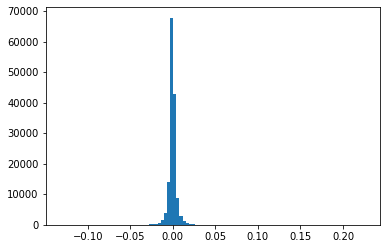

In [731]:
plt.hist(df['iret'], 100)
plt.show()

In [93]:
#dangerous periods, need to check for leveraged positions

#df[df.shortloss.isin(list(df.shortloss.sort_values().head(10)))]
#df[df.longloss.isin(list(df.longloss.sort_values().head(10)))]

0.0507 0.0534 0.0477 0.0502 0.0454 0.0473
corr: position vs vola 0.4584
corr: positionmk vs vola 0.3737
corr: positionmkio vs vola 0.3241


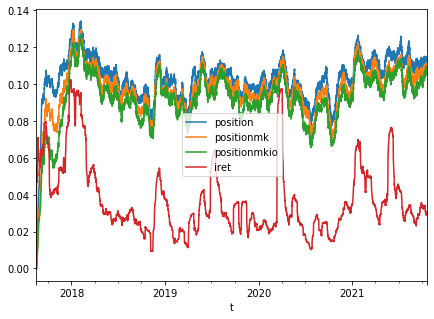

In [215]:
## positions vs volatility
df_ = df.copy()
consct = 3
stddiv = 4*24*365 * 0.002
win = 2000
colstosee = ['position','positionmk','positionmkio']

df_.loc[(df_.constct==consct) & (df_.sign=='neg'),'lgpos'] = 1
df_.loc[(df_.constct==consct) & (df_.sign=='pos'),'shpos'] = 1
df_.loc[(df_.shpos==1) | (df_.lgpos==1),'position'] = 1

df_.loc[(df_.constct==consct) & (df_.sign=='neg') & (df.lgmkin==True),'lgposmk'] = 1
df_.loc[(df_.constct==consct) & (df_.sign=='pos') & (df.shmkin==True),'shposmk'] = 1
df_.loc[(df_.lgposmk==1) | (df_.shposmk==1),'positionmk'] = 1

df_.loc[(df_.constct==consct) & (df_.sign=='neg') & (df.lgmkin==True) & (df.lgmkout==True) ,'lgposmkio'] = 1
df_.loc[(df_.constct==consct) & (df_.sign=='pos') & (df.shmkin==True) & (df.shmkout==True),'shposmkio'] = 1
df_.loc[(df_.lgposmkio==1) | (df_.shposmkio==1),'positionmkio'] = 1

dfroll = df_.rolling(win, min_periods=0)
x = pd.concat([(dfroll.count()[colstosee]/win), dfroll['iret'].std() * np.sqrt(stddiv)], axis=1)
x = pd.concat([df_['t'], x], axis=1).set_index('t')
x.plot(figsize=(7, 5))
print(round(len(df_[df_.lgpos==True]) / len(df_),4), round(len(df_[df_.shpos==True]) / len(df_),4), 
      round(len(df_[df_.lgposmk==True]) / len(df_),4), round(len(df_[df_.shposmk==True]) / len(df_),4),
      round(len(df_[df_.lgposmkio==True]) / len(df_),4), round(len(df_[df_.shposmkio==True]) / len(df_),4))
for v1 in colstosee:
    x_ = x[(x[v1]).notnull() & (x['iret']).notnull()]
    print('corr:', v1, 'vs vola', round(ht.myCorrOrBeta(x_[v1], x_['iret'], corr=True),4))  

In [ ]:
print(df[df.sign!='eq'][(df.constct==consct)].groupby(['sign','nextsame','lgmkin','shmkin']).count()['t'] / df[df.sign!='eq'][(df.constct==consct)].groupby(['sign']).count()['t'])

In [216]:
consct = 3
print(df[df.sign!='eq'][(df.constct==consct)].groupby(['sign','nextsame']).count()['t'] / df[df.sign!='eq'][(df.constct==consct)].groupby(['sign']).count()['t'])
print('')
print('maker entry')
print(df[df.sign!='eq'][(df.constct==consct) & (df.lgmkin==True) & (df.shmkin==True)].groupby(['sign','nextsame']).count()['t'] / df[df.sign!='eq'][(df.constct==consct) & (df.lgmkin==True) & (df.shmkin==True)].groupby(['sign']).count()['t'])
print('')
df[(df.constct==consct) & (df.sign=='pos')].nextiret.sum(), df[(df.constct==consct) & (df.sign=='neg')].nextiret.sum()

sign  nextsame
neg   False       0.609615
      True        0.390385
pos   False       0.590013
      True        0.409987
Name: t, dtype: float64

maker entry
sign  nextsame
neg   False       0.609574
      True        0.390426
pos   False       0.594595
      True        0.405405
Name: t, dtype: float64



(-0.8058613691061427, 2.5168470256432616)

In [622]:
# 5min

sign  nextsame
neg   False       0.551221
      True        0.448779
pos   False       0.540080
      True        0.459920
Name: t, dtype: float64



(-1.8127433946475358, 2.0486154956606724)

In [610]:
## 1h freq

sign  nextsame
neg   False       0.597636
      True        0.402364
pos   False       0.579903
      True        0.420097
Name: t, dtype: float64



(-1.0667479372428226, 0.5518248542441102)

In [234]:
## 30min freq

sign  nextsame
neg   False       0.578830
      True        0.421170
pos   False       0.582405
      True        0.417595
Name: t, dtype: float64



(-1.7976998093933776, 1.6256380275686164)

In [130]:
consct = 3
sl = 0.03
print(df[df.sign!='eq'][(df.constct==consct) & (abs(df.iret)<sl)].groupby(['sign','nextsame']).count()['t'] / df[df.sign!='eq'][(df.constct==consct) & (abs(df.iret)<sl)].groupby(['sign']).count()['t'])
print('')
df[(df.constct==consct) & (df.sign=='pos')].nextiret.sum(), df[(df.constct==consct) & (df.sign=='neg')].nextiret.sum()

sign  nextsame
neg   False       0.621258
      True        0.378742
pos   False       0.605952
      True        0.394048
Name: t, dtype: float64



(-0.9917036618032592, 0.5041857102243139)

In [263]:
sl = 0.03
print(df[df.sign!='eq'][(df.constct==consct) & (abs(df.iret)>sl)].groupby(['sign','nextsame']).count()['t'] / df[df.sign!='eq'][(df.constct==consct) & (abs(df.iret)>sl)].groupby(['sign']).count()['t'])

sign  nextsame
neg   False       0.600000
      True        0.400000
pos   False       0.709677
      True        0.290323
Name: t, dtype: float64


In [786]:
## try 2
print('max loss: long', round(df.loc[(df.constct==3) & (df.sign=='neg')]['longloss'].max(), 4), 'short', round(df.loc[(df.constct==3) & (df.sign=='pos')]['shortloss'].max(), 4))

df.loc[(df.constct==3) & (df.sign=='neg'), 'ls3'] = df.loc[(df.constct==3) & (df.sign=='neg'), 'nextiret']
df.loc[(df.constct==3) & (df.sign=='pos'), 'ls3'] = -df.loc[(df.constct==3) & (df.sign=='pos'), 'nextiret']
df['ls3'].fillna(0, inplace=True)

df.loc[(df.constct==3) & (df.sign=='neg'), 'ls3_2x'] = df.loc[(df.constct==3) & (df.sign=='neg'), 'nextiret'] * 2
df.loc[(df.constct==3) & (df.sign=='pos'), 'ls3_2x'] = -df.loc[(df.constct==3) & (df.sign=='pos'), 'nextiret'] * 2
df['ls3_2x'].fillna(0, inplace=True)

df.loc[(df.constct==3) & (df.sign=='neg'), 'ls3_3x'] = df.loc[(df.constct==3) & (df.sign=='neg'), 'nextiret'] * 3
df.loc[(df.constct==3) & (df.sign=='pos'), 'ls3_3x'] = -df.loc[(df.constct==3) & (df.sign=='pos'), 'nextiret'] * 3
df['ls3_3x'].fillna(0, inplace=True)

max loss: long 0.1486 short 0.0713


In [ ]:
## try risk management

# stop loss
sl = 0.03
df['ls3_sl'] = df['ls3']
df.loc[(df.constct==3) & (df.sign=='neg') & (df.longloss>sl), 'ls3_sl'] = -sl*lev
df.loc[(df.constct==3) & (df.sign=='pos') & (df.shortloss>sl), 'ls3_sl'] = -sl*lev
df['ls3_sl'].fillna(0, inplace=True)

# take profit
tp = 0.03
df['ls3_tp'] = df['ls3']
df.loc[(df.constct==3) & (df.sign=='neg') & (df.shortloss>tp), 'ls3_tp'] = tp*lev
df.loc[(df.constct==3) & (df.sign=='pos') & (df.longloss>tp), 'ls3_tp'] = tp*lev
df['ls3_tp'].fillna(0, inplace=True)

In [ ]:
#maker entry
df['lgmkin'] = (df['o'] - df['l']) > (df['o'] / mkbuffdiv)
df['lgmkin'] = df['lgmkin'].shift(-1) #long maker entry next per
df['shmkin'] = (df['h'] - df['o']) > (df['o'] / mkbuffdiv)
df['shmkin'] = df['lgmkin'].shift(-1) #short maker entry next per

#maker exit
df['lgmkout'] = (df['h'] - df['o']) > (df['o'] / mkbuffdiv)
df['lgmkout'] = df['lgmkout'].shift(-2) #long maker exit in 2 per
df['shmkout'] = (df['o'] - df['l']) > (df['o'] / mkbuffdiv)
df['shmkout'] = df['shmkout'].shift(-2) #short maker exit in 2 per

In [217]:
## try leverage - 2 bd

#x = df.iloc[-100000:].copy()
x = df.copy()

constct = 3
lev = 3
takfee = 0.00075
makfee = -0.00025

#takfee = 0
#makfee = -0

print('max loss: long', round(df.loc[(df.constct==constct) & (df.sign=='neg')]['longloss'].max(), 4), 'short', round(df.loc[(df.constct==constct) & (df.sign=='pos')]['shortloss'].max(), 4))

x = get_ls_lev_nofee_1(x, colname ='ls3_1_no', lev=lev,constct=3, per2=False)
x = get_ls_lev_mk_bd(x, colname ='ls3_1', constct=3, lev=lev, takfee=takfee, makfee=makfee, per2=False)
x = get_ls_lev_mk_1(x, colname='ls3_1_full', constct=3, lev=lev, takfee=takfee, makfee=makfee, per2=False, printcounts=True)

x = get_ls_lev_nofee_1(x, colname ='ls3_2_no', lev=lev,constct=3, per2=True)
x = get_ls_lev_mk_bd(x, colname ='ls3_2', constct=3, lev=lev, takfee=takfee, makfee=makfee, per2=True)
x = get_ls_lev_mk_1(x, colname='ls3_2_full', constct=3, lev=lev, takfee=takfee, makfee=makfee, per2=True)

x = get_ls_lev_nofee_1(x, colname ='ls2_1_no', lev=lev,constct=2, per2=False)
x = get_ls_lev_mk_bd(x, colname ='ls2_1', constct=2, lev=lev, takfee=takfee, makfee=makfee, per2=False)
x = get_ls_lev_mk_1(x, colname='ls2_1_full', constct=2, lev=lev, takfee=takfee, makfee=makfee, per2=False)

x = get_ls_lev_nofee_1(x, colname ='ls2_2_no', lev=lev,constct=2, per2=True)
x = get_ls_lev_mk_bd(x, colname ='ls2_2', constct=2, lev=lev, takfee=takfee, makfee=makfee, per2=True)
x = get_ls_lev_mk_1(x, colname='ls2_2_full', constct=2, lev=lev, takfee=takfee, makfee=makfee, per2=True)

#mx = x15m.groupby(x15m.t.dt.to_period("M") )['iret','ls3_1', 'ls3_2', 'ls2_1', 'ls2_2'].sum().reset_index()
#mx.t = mx.t.apply(lambda x: x.to_timestamp())
#dfres = get_bt(mx, retcols=['iret','ls3_1', 'ls3_2', 'ls2_1', 'ls2_2']) <---- wrong: m ret is not sum of rets in m

dfres.tail(2)

max loss: long 0.1486 short 0.0713
long 7426 6981 6651 330
short 7810 7351 6926 425


,iret,ls3_1,ls3_2,ls2_1,ls2_2
2021-09-01,1332.004504,-44.533128,-132.990784,0.000012,0.119230
2021-10-01,1829.974397,-39.577834,-126.428719,0.000014,0.174441


In [159]:
#x1h = x.copy()
#x15m = x.copy()

In [218]:
# 15m
x15m[['iret'] + list(x15m.columns[-16:])].sum()

iret           4.327602
ls3_1_no       9.968125
ls3_1          1.538390
ls3_1_fee     19.233000
ls3_1_full    20.778140
ls3_2_no      15.714923
ls3_2          5.823709
ls3_2_fee     19.002000
ls3_2_full    24.848209
ls2_1_no       4.813127
ls2_1        -19.018456
ls2_1_fee     45.088500
ls2_1_full    26.090294
ls2_2_no      19.351147
ls2_2         -4.870186
ls2_2_fee     44.647500
ls2_2_full    39.813314
dtype: float64

In [220]:
# 15m
msum = x15m.groupby(x15m.t.dt.to_period("M") )['iret','ls3_1_fee', 'ls3_2_fee', 'ls2_1_fee', 'ls2_2_fee'].sum()
mct = x15m.groupby(x15m.t.dt.to_period("M") )['iret','ls3_1_fee', 'ls3_2_fee', 'ls2_1_fee', 'ls2_2_fee'].count()
#asys.plot_pdf(msum['ls2_1_fee'], label='ls2_1', show=False)
#asys.plot_pdf(msum['ls2_2_fee'], label='ls2_2', show=False)
#asys.plot_pdf(msum['ls3_1_fee'], label='ls3_1', show=False)
#asys.plot_pdf(msum['ls3_2_fee'], label='ls3_2')
msum

,iret,ls3_1_fee,ls3_2_fee,ls2_1_fee,ls2_2_fee
t,,,,,
2017-08,0.155928,0.07350,0.07650,0.1905,0.19650
2017-09,-0.058859,0.24000,0.20700,0.4935,0.51150
2017-10,0.471938,0.17250,0.21675,0.4545,0.41850
2017-11,0.571763,0.30750,0.31425,0.6000,0.64500
2017-12,0.442829,0.46500,0.43800,0.8910,0.91800
2018-01,-0.107447,0.50850,0.50250,1.0290,1.03200
2018-02,0.103819,0.43350,0.42750,0.8745,0.86775
2018-03,-0.361473,0.45450,0.45675,1.0110,0.99975
2018-04,0.299135,0.39000,0.40275,0.9105,0.93750


In [226]:
mct.tail(2)

,iret,ls3_1_fee,ls3_2_fee,ls2_1_fee,ls2_2_fee
t,,,,,
2021-09,2872,2880,2880,2880,2880
2021-10,1792,1792,1792,1792,1792


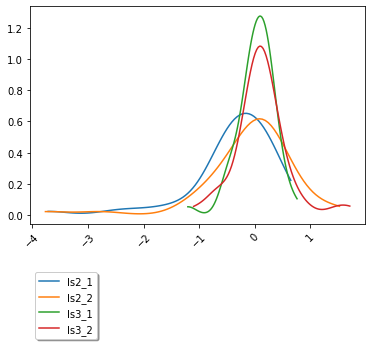

,iret,ls3_1,ls3_2,ls2_1,ls2_2
t,,,,,
2017-08,0.155928,-0.362886,-0.643809,-0.768193,-0.638161
2017-09,-0.058859,-1.203347,-1.099163,-2.510885,-2.772351
2017-10,0.471938,-0.537271,-0.704730,-0.741978,-1.111063
2017-11,0.571763,-0.359469,-0.596119,-1.402262,-0.851623
2017-12,0.442829,-0.399176,-0.142960,-3.716540,-3.765592
2018-01,-0.107447,0.761284,1.709801,-2.061839,-0.935893
2018-02,0.103819,0.576852,1.472573,-1.564085,-0.821101
2018-03,-0.361473,0.226792,0.536154,-0.605189,0.209599
2018-04,0.299135,0.462636,-0.058959,-0.179317,0.330874


In [180]:
# 15m
#msum = x15m.groupby(x15m.t.dt.to_period("M"))['iret','ls3_1_no', 'ls3_1', 'ls3_2_no', 'ls3_2','ls2_1_no', 'ls2_1', 'ls2_2_no', 'ls2_2'].sum()
msum = x15m.groupby(x15m.t.dt.to_period("M"))['iret','ls3_1', 'ls3_2', 'ls2_1', 'ls2_2'].sum()
asys.plot_pdf(msum['ls2_1'], label='ls2_1', show=False)
asys.plot_pdf(msum['ls2_2'], label='ls2_2', show=False)
asys.plot_pdf(msum['ls3_1'], label='ls3_1', show=False)
asys.plot_pdf(msum['ls3_2'], label='ls3_2')
msum

In [140]:
# 1h
x1h[['iret'] + list(x1h.columns[-16:])].sum()

iret           4.363913
ls3_1_no       4.487668
ls3_1          2.226497
ls3_1_fee      4.932000
ls3_1_full     7.162997
ls3_2_no       5.905453
ls3_2          3.276004
ls3_2_fee      5.022000
ls3_2_full     8.309254
ls2_1_no       9.967507
ls2_1          4.431059
ls2_1_fee     12.102000
ls2_1_full    16.539809
ls2_2_no      15.656195
ls2_2          9.889467
ls2_2_fee     12.015000
ls2_2_full    21.922467
dtype: float64

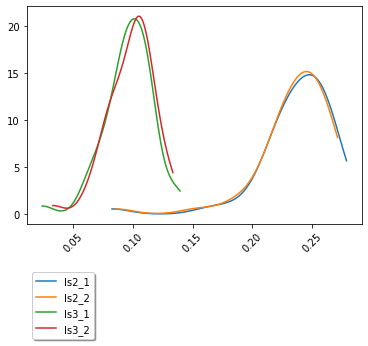

,iret,ls3_1_fee,ls3_2_fee,ls2_1_fee,ls2_2_fee
t,,,,,
2017-08,0.098114,0.0240,0.03300,0.08250,0.08550
2017-09,-0.021657,0.0765,0.08550,0.18300,0.18225
2017-10,0.430293,0.0765,0.07950,0.19950,0.19725
2017-11,0.554135,0.0930,0.10200,0.21450,0.19275
2017-12,0.500723,0.1350,0.12900,0.25875,0.26250
2018-01,-0.159055,0.1110,0.11100,0.26475,0.27075
2018-02,0.118903,0.0930,0.09300,0.23850,0.23475
2018-03,-0.351778,0.1095,0.11250,0.26700,0.24975
2018-04,0.314984,0.0930,0.10425,0.23850,0.23850


In [176]:
# 1h
msum = x1h.groupby(x1h.t.dt.to_period("M") )['iret','ls3_1_fee', 'ls3_2_fee', 'ls2_1_fee', 'ls2_2_fee'].sum()
asys.plot_pdf(msum['ls2_1_fee'], label='ls2_1', show=False)
asys.plot_pdf(msum['ls2_2_fee'], label='ls2_2', show=False)
asys.plot_pdf(msum['ls3_1_fee'], label='ls3_1', show=False)
asys.plot_pdf(msum['ls3_2_fee'], label='ls3_2')
msum

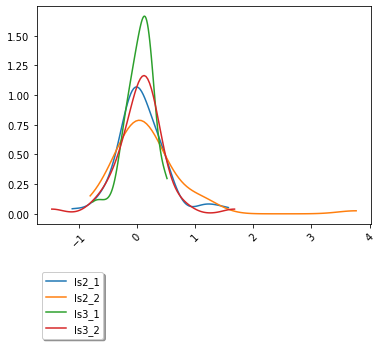

,iret,ls3_1_no,ls3_1,ls3_2_no,ls3_2,ls2_1_no,ls2_1,ls2_2_no,ls2_2
t,,,,,,,,,
2017-08,0.098114,0.287840,0.190491,0.547721,0.372639,1.022293,0.489238,1.097937,0.383028
2017-09,-0.021657,0.227262,-0.025709,0.341104,0.111730,0.387300,-0.559152,0.517038,-0.277408
2017-10,0.430293,0.564838,0.038815,0.849351,0.265815,-0.036550,-0.153724,0.283842,0.451888
2017-11,0.554135,0.351361,0.432525,0.198048,0.129124,0.603269,-0.046223,1.010647,0.495215
2017-12,0.500723,0.028153,-0.249340,1.902879,1.678336,-0.837862,-1.111771,-0.394556,-0.803442
2018-01,-0.159055,0.407915,0.219647,0.777002,0.710901,1.788495,1.572399,4.023990,3.769668
2018-02,0.118903,-0.060596,-0.032666,-0.213603,-0.448322,1.509216,1.241726,1.163297,1.122240
2018-03,-0.351778,0.687979,0.517522,0.616401,0.468811,0.109079,-0.098067,0.123326,0.024506
2018-04,0.314984,0.295038,0.512094,0.234160,0.167839,0.460071,0.392013,0.931664,1.123241


In [175]:
# 1h
msum = x1h.groupby(x1h.t.dt.to_period("M"))['iret','ls3_1_no', 'ls3_1', 'ls3_2_no', 'ls3_2','ls2_1_no', 'ls2_1', 'ls2_2_no', 'ls2_2'].sum()
asys.plot_pdf(msum['ls2_1'], label='ls2_1', show=False)
asys.plot_pdf(msum['ls2_2'], label='ls2_2', show=False)
asys.plot_pdf(msum['ls3_1'], label='ls3_1', show=False)
asys.plot_pdf(msum['ls3_2'], label='ls3_2')
msum

In [319]:
x[x.ls2_1_fee<0].ls2_1_fee.sum(), x[x.ls2_1_fee>0].ls2_1_fee.sum(), x[x.ls2_2_fee<0].ls2_2_fee.sum(), x[x.ls2_2_fee>0].ls2_2_fee.sum()

(-3.453750000000001, 49.788750000000014, -3.453750000000001, 49.78875)

In [227]:
## try leverage - 2 period in

x = df.iloc[-100000:].copy()

constct = 3
lev = 3
takfee = 0.00075
makfee = -0.00025

print('max loss: long', round(df.loc[(df.constct==constct) & (df.sign=='neg')]['longloss'].max(), 4), 'short', round(df.loc[(df.constct==constct) & (df.sign=='pos')]['shortloss'].max(), 4))

x = get_ls_lev_nofee_1(x, colname ='ls3_1', constct=3, per2=False)
x = get_ls_lev_nofee_1(x, colname ='ls3_2', constct=3, per2=True)
x = get_ls_lev_nofee_1(x, colname ='ls2_1', constct=2, per2=False)
x = get_ls_lev_nofee_1(x, colname ='ls2_2', constct=2, per2=True)

dfres = get_bt(x, retcols=['iret','ls3_1','ls3_2','ls2_1','ls2_2'])

max loss: long 0.1486 short 0.0713
done! runtime: 4 min 24 sec


2018-12-13 00:00:00 - 2021-10-19 15:45:00


,iret,ls3_1,ls3_2,ls2_1,ls2_2
2021-10-19 15:30:00,1737.138641,34998.359553,131252.56899,92653.762648,4.171487e+08
2021-10-19 15:45:00,1740.062085,34998.359553,131252.56899,92653.762648,4.171487e+08


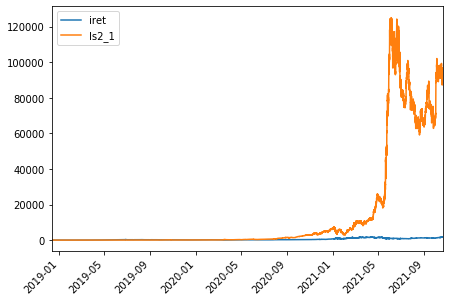

In [236]:
print(str(dfres.index[0]), '-', str(dfres.index[-1]))
dfres.iloc[:,[0,3]].plot(figsize=(7, 5))
plt.xticks(rotation=45)
dfres.tail(2)

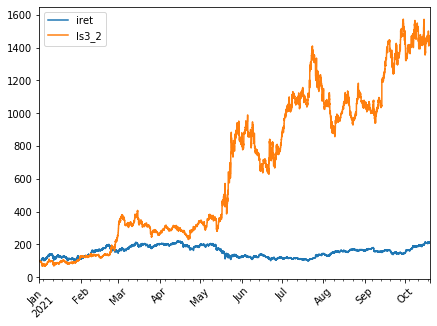

In [238]:
basedate_= '2021-01-01'
todate= '2021-11-01'

x = dfres[(dfres.index>=basedate_) & (dfres.index<=todate)].iloc[:,[0,2]]
x = rebase(x, basedate_=basedate_, baseval=100)
x.plot(figsize=(7, 5))
plt.xticks(rotation=45);

In [222]:
## try maker - 2 period in

x = df.iloc[-100000:].copy()

constct = 3
lev = 3

x = get_ls_lev_mk_1(x, colname='lsmk3_1', constct=3, lev=3, takfee=0.00075, makfee=-0.00025, per2=False, printcounts=True)
x = get_ls_lev_mk_1(x, colname='lsmk3_2', constct=3, lev=3, takfee=0.00075, makfee=-0.00025, per2=True, printcounts=False)

x = get_ls_lev_mk_1(x, colname='lsmk2_1', constct=2, lev=3, takfee=0.00075, makfee=-0.00025, per2=False, printcounts=False)
x = get_ls_lev_mk_1(x, colname='lsmk2_2', constct=2, lev=3, takfee=0.00075, makfee=-0.00025, per2=True, printcounts=False)

dfres1 = get_bt(x, retcols=['iret','lsmk3_1','lsmk3_2','lsmk2_1','lsmk2_2'])

long 5044 4833 4667 166
short 5321 5118 4910 207
done! runtime: 4 min 32 sec


In [390]:
## try maker - 2 period in

x = df.copy()#iloc[-100000:].copy()

constct = 3
lev = 1
x = get_ls_lev_mk_1(x, colname='lsmk3_2', constct=constct, lev=lev, takfee=0.00075, makfee=-0.00025, per2=True, printcounts=False)
x = get_ls_lev_nofee_1(x, colname ='ls3_2', constct=3, lev=lev, per2=True)

#dfres1 = get_bt(x, retcols=['iret','lsmk3_2'])
dfres2 = get_bt(x, retcols=['iret','ls3_2'])

done! runtime: 2 min 38 sec


In [391]:
x[['iret','lsmk3_2','ls3_2']].sum()

iret       4.327602
lsmk3_2    8.611992
ls3_2      5.236625
dtype: float64

2017-08-17 06:00:00 - 2021-10-19 15:45:00


,iret,lsmk3_2
2021-10-19 15:30:00,1246.754501,347444.509679
2021-10-19 15:45:00,1248.852674,347444.509679


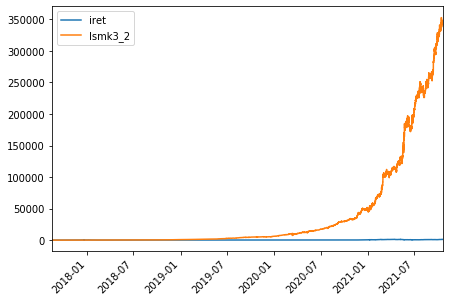

In [382]:
print(str(dfres1.index[0]), '-', str(dfres1.index[-1]))
dfres1.iloc[:,:].plot(figsize=(7, 5))
plt.xticks(rotation=45)
dfres1.tail(2)

,iret,lsmk3_2
2020-05-31 23:45:00,243.887191,1679.43582
2020-06-01 00:00:00,244.789147,1682.33136


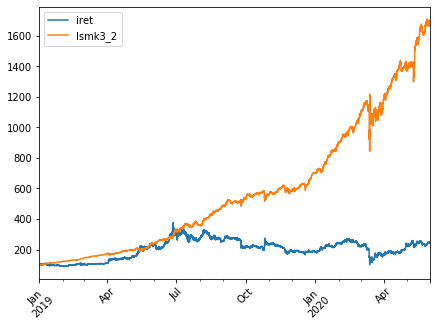

In [400]:
basedate_= '2019-01-01'
todate= '2020-06-01'

x = dfres1[(dfres1.index>=basedate_) & (dfres1.index<=todate)].iloc[:,:]
x = rebase(x, basedate_=basedate_, baseval=100)
x.plot(figsize=(7, 5))
plt.xticks(rotation=45);
x.tail(2)

,iret,ls3_2
2020-05-31 23:45:00,243.887191,294.208641
2020-06-01 00:00:00,244.789147,294.642339


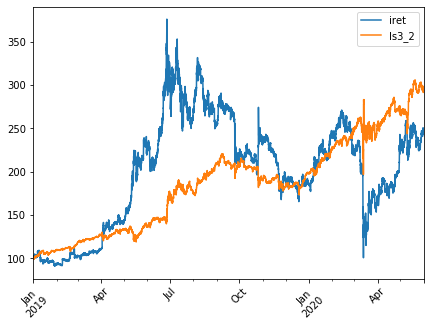

In [399]:
basedate_= '2019-01-01'
todate= '2020-06-01'

x = dfres2[(dfres2.index>=basedate_) & (dfres2.index<=todate)].iloc[:,:]
x = rebase(x, basedate_=basedate_, baseval=100)
x.plot(figsize=(7, 5))
plt.xticks(rotation=45);
x.tail(2)

In [397]:
sl = 0.02 #above 2% less likely to revert
print('all', df.loc[(df.constct==3) & (df.sign!='eq') & ((df.iret>sl) | (df.iret<-sl))].groupby('nextsame').count()['t'] / df.loc[(df.constct==3) & (df.sign!='eq') & ((df.iret>sl) | (df.iret<-sl))].count()['t'])
print('pos', df.loc[(df.constct==3) & (df.sign!='eq') & (df.sign=='pos') & (df.iret>sl)].groupby('nextsame').count()['t'] / df.loc[(df.constct==3) & (df.sign!='eq') & (df.sign=='pos') & (df.iret>sl)].count()['t'])
print('neg', df.loc[(df.constct==3) & (df.sign!='eq') & (df.sign=='neg') & (df.iret<-sl)].groupby('nextsame').count()['t'] / df.loc[(df.constct==3) & (df.sign!='eq') & (df.sign=='neg') & (df.iret<-sl)].count()['t'])

all nextsame
False    0.583333
True     0.416667
Name: t, dtype: float64
pos nextsame
False    0.634146
True     0.365854
Name: t, dtype: float64
neg nextsame
False    0.54918
True     0.45082
Name: t, dtype: float64


In [371]:
print(round(len(dfll[dfll.nextiret<-sl]) / len(dfll),4), 'of times sl by long is good')
print(round(len(dfshl[dfshl.nextiret>sl]) / len(dfshl),4), 'of times sl by short is good')

0.3929 of times sl by long is good
0.3939 of times sl by short is good


In [425]:
## stop loss
lev = 1
sl = 0.02
dfll = df.loc[(df.constct==3) & (df.sign=='neg') & (df.longloss>sl/lev)]
dfshl = df.loc[(df.constct==3) & (df.sign=='pos') & (df.shortloss>sl/lev)]

print(round(len(dfll[dfll.nextiret<-sl]) / len(dfll),4), 'of times sl by long is good')
print(round(len(dfshl[dfshl.nextiret>sl]) / len(dfshl),4), 'of times sl by short is good')
print('sl by long loss:', round((dfll.nextiret + sl).sum(),4), 'sl by short loss:', round(-(dfshl.nextiret - sl).sum(), 4))

0.4672 of times sl by long is good
0.4605 of times sl by short is good
sl by long loss: 0.0795 sl by short loss: -0.0117


In [458]:
## take profit
tp = 0.03
dflp = df.loc[(df.constct==3) & (df.sign=='neg') & (df.shortloss>tp)]
dfshp = df.loc[(df.constct==3) & (df.sign=='pos') & (df.longloss>tp)]

print(round(len(dflp[dflp.nextiret<tp]) / len(dflp),4), 'of times tp by long is good')
print(round(len(dfshp[dfshp.nextiret>-tp]) / len(dfshp),4), 'of times tp by short is good')
print('tp by long profit:', round(-(dflp.nextiret - tp).sum(), 4), 'sl by short profit:', round((dfshp.nextiret+tp).sum(), 4))

0.5385 of times tp by long is good
0.8 of times tp by short is good
tp by long profit: -0.0786 sl by short profit: 0.127


In [150]:
## calculate portfolio timeseries

#df = df.tail(5000).copy().reset_index(drop=True) ## slice it for testing

#calc portfolios
#retcols = ['iret','long3', 'short3', 'longshort3', 'long2', 'short2','longshort2']
#retcols = ['nextiret','ls3', 'ls3_2x', 'ls3_3x']
#retcols = ['nextiret','ls3_2x']
#retcols = ['nextiret','ls3','ls3_sl','ls3_tp']
retcols = ['nextiret','ls3','ls3_mk_io'] #ls3_mk_no
basedate = df.t[0]

t1 = dt.datetime.now()

dfres = pd.DataFrame()
for retcol in retcols:
    dfres = pd.concat([dfres, rets_to_ts(df[['t',retcol]], basedate, baseval=100, datecol='t', dropfirstrow=False)], axis=1)

timeit(t1, msg='done!')

done! runtime: 3 min 58 sec


In [40]:
#dfr06 = dfres.copy()  #mkbuffdiv = 100000
#dfr2 = dfres.copy()  #mkbuffdiv = 30000

2017-08-17 06:00:00 - 2021-10-19 15:45:00


,nextiret,ls3,ls3_mk_io
2021-10-19 15:30:00,1248.852674,271159.050026,1.029734e+06
2021-10-19 15:45:00,1248.852674,271159.050026,1.029734e+06


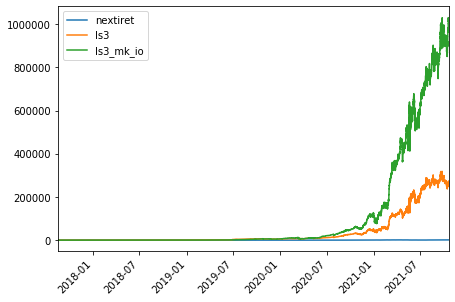

In [152]:
print(str(dfres.index[0]), '-', str(dfres.index[-1]))
dfres.iloc[:,:].plot(figsize=(7, 5))
plt.xticks(rotation=45)
dfres.tail(2)

2017-08-17 06:00:00 - 2021-10-19 15:45:00


,nextiret,ls3,ls3_mk_in,ls3_mk_io
2021-10-19 15:30:00,1248.852674,271159.050026,4.065867e+07,219163.069474
2021-10-19 15:45:00,1248.852674,271159.050026,4.065867e+07,219163.069474


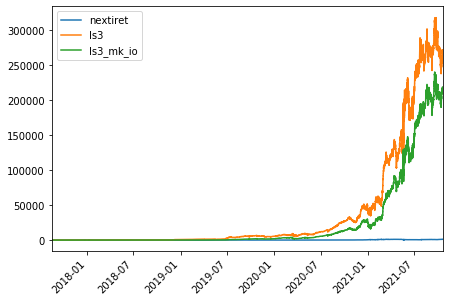

In [42]:
print(str(dfr2.index[0]), '-', str(dfr2.index[-1]))
dfr2.iloc[:,[0,1,3]].plot(figsize=(7, 5))
plt.xticks(rotation=45)
dfr2.tail(2)

2017-08-17 06:00:00 - 2021-10-19 15:45:00


,nextiret,ls3,ls3_mk_in,ls3_mk_io
2021-10-19 15:30:00,1248.852674,271159.050026,1.249618e+08,1.076810e+06
2021-10-19 15:45:00,1248.852674,271159.050026,1.249618e+08,1.076810e+06


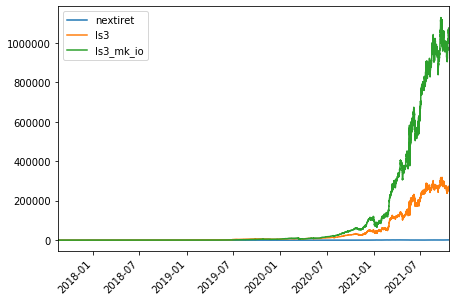

In [41]:
print(str(dfr06.index[0]), '-', str(dfr06.index[-1]))
dfr06.iloc[:,[0,1,3]].plot(figsize=(7, 5))
plt.xticks(rotation=45)
dfr06.tail(2)

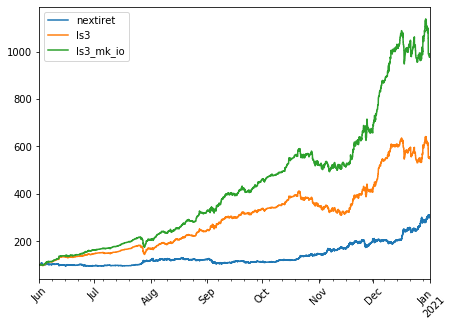

In [30]:
basedate_= '2020-06-01'
todate= '2021-01-01'

x = dfres[(dfres.index>=basedate_) & (dfres.index<=todate)].iloc[:,[0,1,3]]
x = rebase(x, basedate_=basedate_, baseval=100)
x.plot(figsize=(7, 5))
plt.xticks(rotation=45);

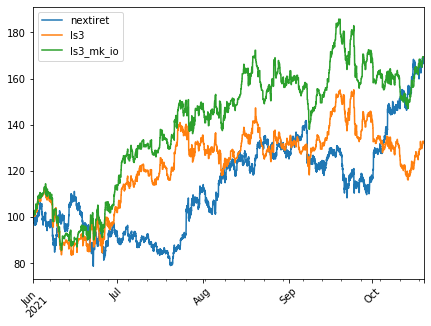

In [46]:
basedate_= '2021-06-01'
todate= '2021-11-01'

x = dfres[(dfres.index>=basedate_) & (dfres.index<=todate)].iloc[:,[0,1,3]]
x = rebase(x, basedate_=basedate_, baseval=100)
x.plot(figsize=(7, 5))
plt.xticks(rotation=45);

2017-08-17 06:00:00 - 2021-10-19 15:45:00


,nextiret,ls3,ls3_sl,ls3_tp
2021-10-19 15:30:00,1248.852674,178386.826697,115399.544323,221565.896083
2021-10-19 15:45:00,1248.852674,178386.826697,115399.544323,221565.896083


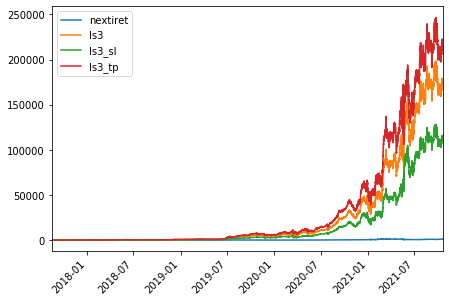

In [1176]:
print(str(dfres15min.index[0]), '-', str(dfres15min.index[-1]))
dfres15min.iloc[:,:].plot(figsize=(7, 5))
plt.xticks(rotation=45)
dfres15min.tail(2)

2017-08-17 06:00:00 - 2021-10-19 15:45:00


,nextiret,ls3,ls3_sl,ls3_tp
2021-10-19 15:30:00,1248.852674,196112.532596,128280.56643,215543.10065
2021-10-19 15:45:00,1248.852674,196112.532596,128280.56643,215543.10065


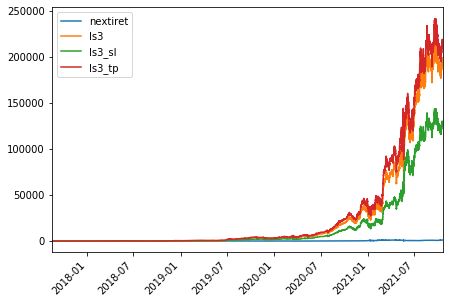

In [766]:
print(str(dfres15minfix50.index[0]), '-', str(dfres15minfix50.index[-1]))
dfres15minfix50.iloc[:,:].plot(figsize=(7, 5))
plt.xticks(rotation=45)
dfres15minfix50.tail(2)

2017-08-17 06:00:00 - 2021-10-19 15:45:00


,nextiret,ls3,ls3_sl,ls3_tp
2021-10-19 15:30:00,1248.852674,0.858701,0.561558,0.943895
2021-10-19 15:45:00,1248.852674,0.858701,0.561558,0.943895


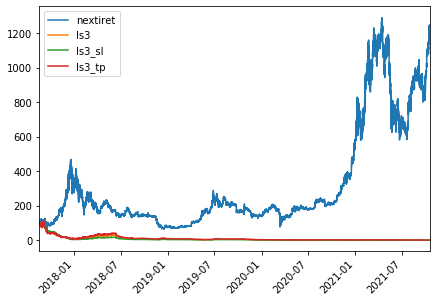

In [765]:
print(str(dfres15minfix50takfee.index[0]), '-', str(dfres15minfix50takfee.index[-1]))
dfres15minfix50takfee.iloc[:,:].plot(figsize=(7, 5))
plt.xticks(rotation=45)
dfres15minfix50takfee.tail(2)

2017-08-17 06:00:00 - 2021-10-19 15:45:00


,nextiret,ls3,ls3_mk_in
2021-10-19 15:30:00,1248.852674,271159.050026,171.311548
2021-10-19 15:45:00,1248.852674,271159.050026,171.311548


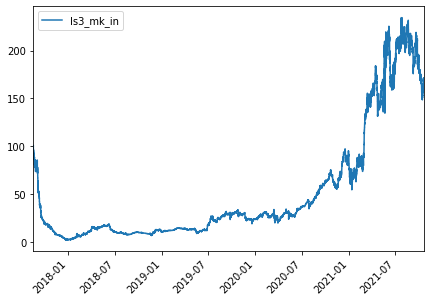

In [1036]:
print(str(dfres.index[0]), '-', str(dfres.index[-1]))
dfres.iloc[:,2:].plot(figsize=(7, 5))
plt.xticks(rotation=45)
dfres.tail(2)

In [1034]:
dfres.iloc[:,1:]

,ls3,ls3_mk_in
2017-08-17 06:00:00,100.000000,100.000000
2017-08-17 06:00:00,100.000000,100.000000
2017-08-17 06:15:00,100.000000,100.000000
2017-08-17 06:30:00,100.000000,100.000000
2017-08-17 06:45:00,100.000000,100.000000
...,...,...
2021-10-19 14:45:00,272535.003851,171.311548
2021-10-19 15:00:00,272535.003851,171.311548
2021-10-19 15:15:00,272535.003851,171.311548
2021-10-19 15:30:00,271159.050026,171.311548


2017-08-17 06:00:00 - 2021-10-19 15:45:00


,nextiret,ls3,ls3_sl,ls3_tp
2021-10-19 15:30:00,1248.852674,196112.532596,128280.56643,215543.10065
2021-10-19 15:45:00,1248.852674,196112.532596,128280.56643,215543.10065


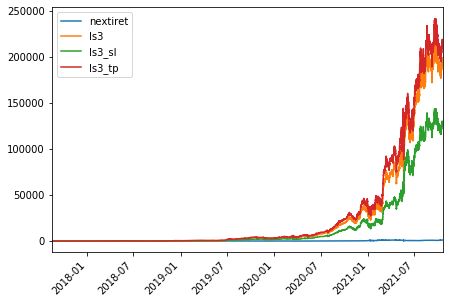

In [758]:
print(str(dfres.index[0]), '-', str(dfres.index[-1]))
dfres.iloc[:,:].plot(figsize=(7, 5))
plt.xticks(rotation=45)
dfres.tail(2)

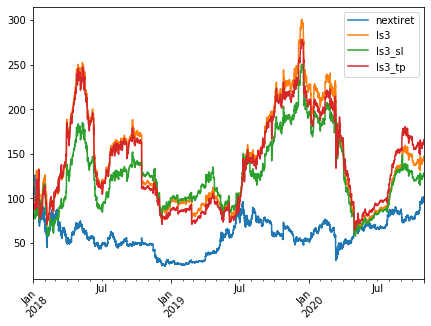

In [781]:
basedate_= '2018-01-01'
todate= '2020-11-01'

#dfres = dfres[1:].copy()
x = dfres[(dfres.index>=basedate_) & (dfres.index<=todate)].iloc[:,:]
x = rebase(x, basedate_=basedate_, baseval=100)
x.plot(figsize=(7, 5))
plt.xticks(rotation=45);

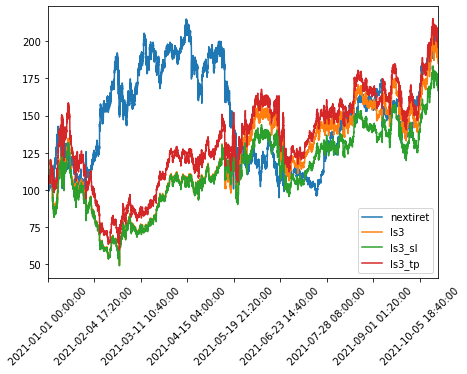

In [700]:
basedate_= '2021-01-01'
todate= '2021-11-01'

#dfres = dfres[1:].copy()
x = dfres[(dfres.index>=basedate_) & (dfres.index<=todate)].iloc[:,:]
x = rebase(x, basedate_=basedate_, baseval=100)
x.plot(figsize=(7, 5))
plt.xticks(rotation=45);

In [698]:
x.tail()

,nextiret,ls3,ls3_sl,ls3_tp
2020-04-30 23:35:00,119.016264,52201.716156,50384.407697,65802.050523
2020-04-30 23:40:00,118.480143,52201.716156,50384.407697,65802.050523
2020-04-30 23:45:00,118.334857,52201.716156,50384.407697,65802.050523
2020-04-30 23:50:00,118.197529,52201.716156,50384.407697,65802.050523
2020-04-30 23:55:00,117.741435,51597.416401,49801.145546,65040.309991


In [685]:
#list(dfstat.level_0.drop_duplicates())
dftest = dfres.copy()
#dftest.index = pd.to_datetime(dftest.index, format='%Y-%m-%d', dayfirst=True) # <--------------------------- if needed
dailyfreq = np.array(dftest.index[:-1])[dftest.index[:-1].time > dftest.index[1:].time]
dftest = dftest[dftest.index.isin(dailyfreq)].copy()
dfstat = ht.calc_stats(dftest, freq='d', periods=[1,2,3,4], bm_col='nextiret')
dfstat = dfstat.reset_index()
list1 = ['Ret mean ann.','StDev ann.','MaxDD']
dfstat[dfstat.level_0.isin(list1)]

,level_0,level_1,nextiret,ls3,ls3_sl,ls3_tp
10,Ret mean ann.,from 2017-08-17,0.582354,1.976581,1.944565,2.135834
11,Ret mean ann.,4y,0.558267,1.946475,1.927421,2.084803
12,Ret mean ann.,3y,0.679363,2.316968,2.259345,2.382031
13,Ret mean ann.,2y,0.859940,2.222920,2.173713,2.281366
14,Ret mean ann.,1y,1.421294,1.399119,1.251823,1.423244
15,StDev ann.,from 2017-08-17,0.704993,0.827946,0.828946,0.844740
16,StDev ann.,4y,0.664196,0.805932,0.804154,0.824746
17,StDev ann.,3y,0.608485,0.678631,0.687030,0.674152
18,StDev ann.,2y,0.616987,0.718202,0.728467,0.708766
19,StDev ann.,1y,0.665374,0.804481,0.825188,0.787443


In [ ]:
ht.calc_stats(dftest, freq='d', periods=[], bm_col='NSDQ100')

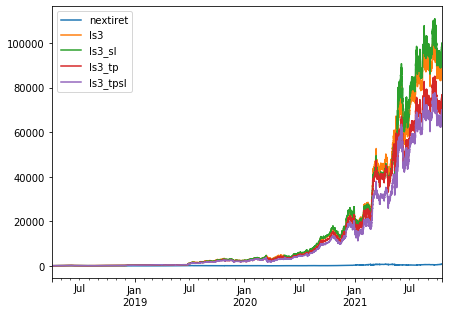

In [522]:
basedate_= '2018-04-01'
todate= '2021-11-01'
x = dfres[(dfres.index>=basedate_) & (dfres.index<=todate)].iloc[:,:]
rebase(x, basedate_=basedate_, baseval=100).plot(figsize=(7, 5));

2017-08-17 06:00:00 - 2021-10-19 15:45:00


,iret,long3,short3,longshort3,long2,short2,longshort2
2021-10-19 15:30:00,1246.754501,878.253482,221.750642,1947.532732,125.116128,176.162278,220.407421
2021-10-19 15:45:00,1248.852674,878.253482,221.750642,1947.532732,125.116128,176.162278,220.407421


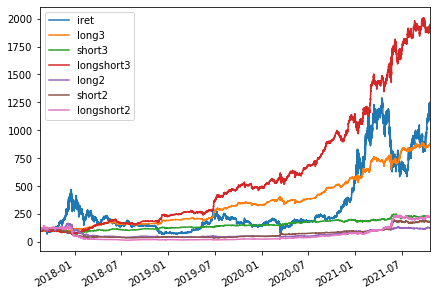

In [85]:
print(str(dfres.index[0]), '-', str(dfres.index[-1]))
dfres.iloc[:,:].plot(figsize=(7, 5))
dfres.tail(2)

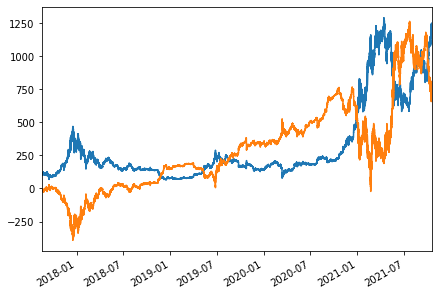

In [89]:
dfres['iret'].plot(figsize=(7, 5))
((dfres['longshort3'] - dfres['nextiret'])).plot(figsize=(7, 5))

In [ ]:
#TO DO
# try alternating long short depending on the short term trend: on uptrend only long (prio 2)

In [113]:
str(a)

'[608683, 608052, 608043, 606207, 605721, 605496, 605214, 602483, 602482, 600983, 599378, 599367, 599076, 598921, 598483, 597568, 597567, 595192, 594697, 593907, 593699, 593498, 593333, 593190, 593189, 592906, 592576, 591319, 591063, 590333, 590316, 589558, 589444, 589368, 588863, 588335, 588249, 587876, 587875, 587253, 586847, 586846, 586669, 586668, 586381, 586380, 586236, 586235, 585415, 578943, 578572, 578571, 578161, 577821, 577192, 577062, 575474, 574280, 574062, 573774, 573493, 572762, 572724, 571501, 571230, 571088, 570667, 570286, 570285, 568574, 568560, 568183, 566910, 565360, 565359, 564933, 564551, 562229, 562077, 560423, 560418, 559500, 559494, 559204, 559199, 557932, 554505, 553423, 553422, 552191, 552030, 550427, 549955, 548031, 547316, 546969, 546968, 546837, 545325, 544629, 541751, 541449, 539515, 539112, 538299, 537929, 537720, 537719, 536933, 536932, 536832, 531965, 528517, 527599, 525874, 525049, 524956, 521421, 521420, 521294, 519698, 519538, 519177, 517728, 512822